grid = [[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
  100. 100. 100. 100. 100. 100.]
 [  0.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.
   15.  15.  15.  15.  15.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.  

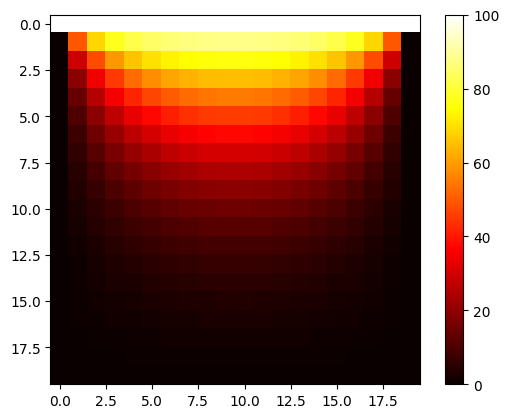

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange

N = 20
grid = np.zeros((N, N))
cx = cy = N // 2

grid[0,:] = 100.0
alpha = 0.15

@njit(parallel=True)
def ca_step(G):
    H = G.copy()
    for i in prange(1, G.shape[0]-1):
        for j in range(1, G.shape[1]-1):
            H[i, j] = (
                G[i, j] +
                alpha * (
                    G[i+1, j] +
                    G[i-1, j] +
                    G[i, j+1] +
                    G[i, j-1] -
                    4 * G[i, j]
                )
            )
    return H

# run simulation
for t in range(200):
    grid = ca_step(grid)
    if t % 50 == 0:
        print(f"grid = {grid}")

plt.imshow(grid, cmap="hot")
plt.colorbar()
plt.show()
